## LangGraph

LangGraph is a framework which is used for building adaptable AI agents. It is build on top of langchain, and provides a flexible and intutive way to build highly customizable and state agnostic multi agentic applications. It allows to define a workflow as directed acyclic graphs (DAGs), where each node in the graph represents a specific action or AI agent, and edges define the flow of control. 

### Core Concepts

Let's break down the fundamental building blocks of a LangGraph application:

1. **Graph**: The central component, representing your application's workflow as a collection of nodes and edges.
2. **Nodes**: These are the "actors" or "steps" in your workflow. It represents any specefic action or AI agent. A node can be:
    - An LLM call
    - A tool invocation (e.g., a search API, a calculator)
    - A custom Python function
    - Another LangChain runnable
3. **Edges**: These define the transitions between nodes. They dictate which node executes next after a particular node completes. Edges can be:
    - **Conditional Edges**: Based on the output of a node, the graph can transition to different subsequent nodes.
    - **Direct Edges**: Simply point from one node to the next.
4. **State**: While LangGraph itself is state-agnostic in its node execution, you often define a shared "graph state" that is passed between nodes. Each node can read from and write to this state. This state is often defined as a TypedDict. 
5. **Entry Point (START)**: The designated starting node for your graph's execution.
6. **Finish Point (END)**: A special marker signifying the conclusion of a workflow path.

This notebook will guide you through the fundamental steps of constructing a graph, including defining its state, adding simple Python functions as nodes, connecting them with edges, setting a starting point, and compiling it. We'll then significantly enhance our graph by integrating external tools like WikipediaQueryRun and TavilySearchResults, and demonstrating how to wrap a custom function into a tool (In 3.2 tools notebook).


### Step-by-Step : Building a Simple Graph

Let's start with a basic graph structure as mentioned above, which initialy takes your first name as input, then adds your last name in the result. This will help us ensure our foundational understanding. This also introduces the concept of a "headless" graph where the node function directly takes the input of the graph as its parameter and returns its output, rather than operating on a shared TypedDict state. While StateGraph is more common for complex workflows, Graph (the simpler version) is ideal for basic sequential chains like this.

In [1]:
## we have created two fucntion
## first one will take your first name as input
def first_name(input1):
    return input1 

## in our graph return from first function will work as input for second function
def last_name(input2):
    return input2 + " Sharma"

print(last_name(first_name('Ashutosh')))

Ashutosh Sharma


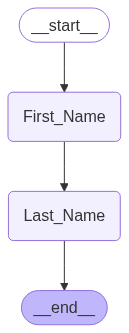

In [2]:
## orchestrate these function using langgraph
from langgraph.graph import Graph

## Building the graph
workflow_name = Graph()
## adding first_name as a node
workflow_name.add_node('First_Name', first_name)
## adding second name as node
workflow_name.add_node('Last_Name', last_name)
## adding edges from 1st function to 2nd
## result from first node will be passed to second node
workflow_name.add_edge('First_Name','Last_Name')
## set the entry point of our graph
workflow_name.set_entry_point('First_Name')
## set the finish point
workflow_name.set_finish_point('Last_Name')
## compile the graph
app = workflow_name.compile()
app


In [3]:
for output in app.stream("Ashutosh"):
    for key,value in output.items():
        print(f"Here is output from :  {key}")
        print("-"*30)
        print(f"Here is output :  {value}\n")

Here is output from :  First_Name
------------------------------
Here is output :  Ashutosh

Here is output from :  Last_Name
------------------------------
Here is output :  Ashutosh Sharma



Now, let's look at a very common pattern: passing the output of one step (an LLM call) directly as input to the next step (a token counter). Another example of Headless Graph

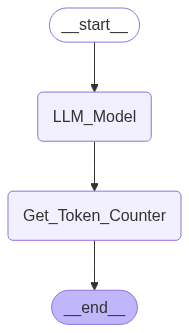

In [4]:
from langchain_openai import ChatOpenAI
def llm(input):
    model= ChatOpenAI(model='gpt-4o-mini')
    output = model.invoke(input)
    return output.content

def token_counter(input):
    token = str(input).split()
    count_no = len(token)
    return count_no

workflow2 = Graph()
workflow2.add_node('LLM_Model',llm)
workflow2.add_node('Get_Token_Counter',token_counter)
workflow2.add_edge('LLM_Model','Get_Token_Counter')
workflow2.set_entry_point('LLM_Model')
workflow2.set_finish_point('Get_Token_Counter')
app2 = workflow2.compile()
app2

In [5]:
for output in app2.stream("what is an AI Agent?"):
    for key,value in output.items():
        print(f"Here is output from :  {key}")
        print("-"*30)
        print(f"Here is output from :  {value}")

Here is output from :  LLM_Model
------------------------------
Here is output from :  An AI agent is a system or software that uses artificial intelligence techniques to perform tasks autonomously or semi-autonomously in a given environment. AI agents can perceive their environment, process information, and make decisions based on predefined algorithms, machine learning models, or other AI methods.

There are various types of AI agents, including:

1. **Reactive Agents**: These agents respond directly to their environment without maintaining a significant internal state or memory. They operate based on a set of predefined rules.

2. **Deliberative Agents**: These agents maintain an internal model of the world and can plan their actions based on that model. They can reason about future states and outcomes.

3. **Learning Agents**: These agents improve their performance over time through experience. They employ machine learning techniques to adapt their behavior based on past interactio

Key Takeaways from this Example:

1.  **Graph() vs. StateGraph()**:
    - Graph() is simpler. It's used when the output of one node directly becomes the input of the next. There's no explicit TypedDict for a shared state that all nodes read from and write to.
    - StateGraph() (used in previous and next examples) is for more complex scenarios where multiple nodes might read/write different parts of a shared, evolving state, often involving conditional logic or parallel execution.
2. **Direct Input/Output Flow**: In Graph(), workflow2.add_edge('LLM_Model', 'Get_Token_Counter') means that whatever llm() returns will be passed as the single positional argument to token_counter().
3. **set_finish_point()**: This explicitly tells LangGraph which node's output should be returned as the final result of app2.invoke().

## Core Components deep dive

### State

The first thing we do when we deine a **Graph** is define the **State** of the graph. The **State** schema serves as the input schema for all Nodes and Edges in the graph. We define state as TypeDict. TypeDict work as a plain dict at runtime.

In [6]:
from typing import TypedDict

class State(TypedDict):
    ## we will only define a single key graph_state for this example
    graph_state: str

### Nodes

As mentioned above nodes represent any actions or a function. The first positional argument is the State. Each node operates on the state. Also each node will override the prior state value.

In [7]:
def node_1(state):
    print('--Node1--')
    return {'graph_state': state['graph_state'] + "I am"}

def node_2(state):
    print('--Node2--')
    return {'graph_state': state['graph_state'] + " happy"}

def node_3(state):
    print('--Node3--')
    return {'graph_state': state['graph_state'] + " sad"}

In [9]:
node_2({"graph_state":""})

--Node2--


{'graph_state': ' happy'}

### Edges

Edges connects the nodes. Normal edges are used if you want to always go from first node to second.

Conditional Edges are used when we need to conditionaly route between the nodes

In [26]:
import random
from typing import Literal

## conditional edge function
## function to define conditional edge
## randomly we will decide which node to route
def mood(state) -> Literal["node_2","node_3"]:
    
    user_input = state['graph_state']
    
    ## 50% of the time we will return node2
    if random.random() > 0.5:
        return 'call node_2'
    
    ## rest 50% we will return node3
    return 'call node_3'

In [27]:
mood({'graph_state':"Hi"})

'call node_3'

Nodes update the state whereas conditional edge decide which node to go to next.

### Graph Construction

We will use **StateGraph** class to define our graph. 

1. First we will initialize a StateGraph with the State class which we have defined above. 
2. Then we will add nodes and edges to it.
3. Then we will use START node which sends user input to the graph or indicate where to start the graph.
4. Then we will define END node which represent a terminal node.
5. Compile our graph, do basic check.
6. Vizualize the graph.

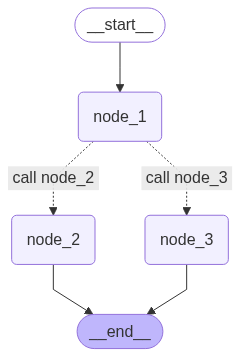

In [28]:
from langgraph.graph import StateGraph, START, END

## Build graph
workflow = StateGraph(State)
workflow.add_node('node_1',node_1)
workflow.add_node('node_2',node_2)
workflow.add_node('node_3',node_3)

## Define the flow
workflow.add_edge(START,'node_1')
workflow.add_conditional_edges(
    'node_1',
    mood,
    {
        'call node_2':'node_2',
        'call node_3':'node_3'
    }
)
workflow.add_edge('node_2',END)
workflow.add_edge('node_3',END)

## Compile our graph
app = workflow.compile()

## View the Graph
app

### Graph Invocation

The compiled graph implements the runnable protocal. Therefore we can execute it using invoke methods.

When invoke is called, the graph starts execution from the START node. The progress through the defined node in order. The conditional node will travers from 1 to 2 or 3 using the condition. Each nodes function receives the current state and override it. The execution continues until it reaches the END node.

In [33]:
try:
    print(app.invoke({"graph_state":"Hi, my name is Ashutosh."}))
except Exception as e:
    print(f'Exception : {e}')

--Node1--
--Node2--
{'graph_state': 'Hi, my name is Ashutosh.I am happy'}


invoke runs the entire graph synchronously. It waits for each step to complete before it moving to the next step. It returns the final state once all the nodes of the graph have been executed.

## Building Chain

We are aware with the core components of LangGraph. Now we will learn to build chains which will combine 4 key concepts:
1. Using chat messages in ou graph.
2. Using chat models.
3. Binding tools to our LLM.
4. Executing tool calls in our graph.

### Messages

Chat models use messages which captures the different roles within a conversation. LangChain supports various message type
 - HumanMessage
 - AIMessage
 - SystemMessage
 - ToolMessage

Let's create a list of few messages and we will supply each message with some information:
    - content : content of the message.
    - name : optional, who is creating the message.
    - response_metadata : optional, a dict of metadata that is specific to each model provider.

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content=f'So you were researching about LangGraph?',name='Model')]
messages.extend([HumanMessage(content=f'Yes', name='Ashu')])
messages.extend([AIMessage(content=f'What would you want to learn about?',name='Model')])
messages.extend([HumanMessage(content=f'I want to learn about stategraph in langgraph', name='Ashu')])

for msg in messages:
    msg.pretty_print()
    
## We will take the list of this message list and will pass it to our chat model

================================== Ai Message ==================================
Name: Model

So you were researching about LangGraph?
================================ Human Message =================================
Name: Ashu

Yes
================================== Ai Message ==================================
Name: Model

What would you want to learn about?
================================ Human Message =================================
Name: Ashu

I want to learn about stategraph in langgraph


### Chat Model

Chat model can use the sequence of messages as input and support roles.

In [3]:
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o-mini')
result = llm.invoke(messages)
print(result.content[0:200])
print(f'\n{result.response_metadata}')

In LangGraph, a StateGraph is a structure that is used to represent different states and transitions between those states within a language model framework. While specific implementations may vary, he

{'token_usage': {'completion_tokens': 263, 'prompt_tokens': 56, 'total_tokens': 319, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BhVCwLPIkEWD7OVWL95fST4eXvEas', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}


### Tools

Tools are needed whenever we want a model to control parts of our code to call external APIs. Most of the LLMs support tool calling. In LangChain we can pass any function to ChatModel.bind_tool().

In [84]:
from langchain_core.tools import tool

@tool
def multiply(a:int, b:int) ->int:
    "Multiply a and b"
    return a*b

## Binding tool with LLM model
llm_with_tool = llm.bind_tools([multiply])

In [85]:
tool_call = llm_with_tool.invoke('what is 2 multiply by 3')
tool_call
## So we found that there is no content in AIMessage but there is a tool call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uAeYMq9QkpZkqCDhleuEPTVP', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 53, 'total_tokens': 70, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-BhlOG22S7SNYNWzv2x4Z55X2ezfB5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d48e32c1-63d2-4a8f-b0b6-1c8b10745a7a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_uAeYMq9QkpZkqCDhleuEPTVP', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'output_tokens': 17, 'total_tokens': 70, 'input_token_details': {'audio': 0, 'cach

In [86]:
## We can see that it is calling a function multiply and providing the arguments
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_uAeYMq9QkpZkqCDhleuEPTVP',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

### Using Messages as State

We can use these messages as state. We will define our state class. Define it as TypedDict with a single key: messages, where messages will be a list of messages.

In [87]:
from typing import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
    messages: list[AnyMessage]

### Reducers

As we discussed earlier that as our graph runs, each node overrides the prior state. Whereas we would want to preserve our messages, so that means we would want to append messages to our message state key.

To overcome this we use Reducer functions.

Reducer functions allow us to specify how the state would be updated. If no reducer function is specified that it would update to the key should be override. Since we want to append our messages we would use a pre-build reducer add_messages.

We will annotate our key with the reducer function as metadata.

In [88]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

### Building a Graph using MessageState and calling tools

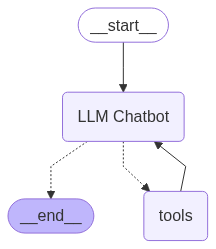

In [96]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, AnyMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

## llm
llm = ChatOpenAI(model='o3-mini')

tavily_tool = TavilySearchResults(max_results=3)

@tool
def multiply(a:int,b:int)->int:
    """this tool will do multiplication"""
    return a*b

@tool
def add(a:int, b:int) -> int:
    "Add two integers"
    return a+b

tools_list = [tavily_tool, multiply, add]

## Binding tools with llm
llm_with_tool = llm.bind_tools(tools_list)

## defining stateclass
class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

## ToolNode runs the tools which are called in last AIMessage
## If there are multiple tools called, it will run in parallel
tool_call = ToolNode([tavily_tool, multiply, add])

def llm_chatbot(state: State):
    return {'messages': [llm_with_tool.invoke(state['messages'])]}

## Graph
build = StateGraph(State)
build.add_node('LLM Chatbot', llm_chatbot)
build.add_node('tools',tool_call)
build.add_edge(START,'LLM Chatbot')
build.add_conditional_edges(
    "LLM Chatbot",
    ## it route to the ToolNode if last message has tool calls
    tools_condition,
)
build.add_edge('tools','LLM Chatbot')

app = build.compile()
app

In [92]:
## natural response
app.invoke({'messages': 'Hi'})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='f8b71577-6628-435e-8a1d-365dfd8abf92'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 124, 'total_tokens': 211, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_e20469f047', 'id': 'chatcmpl-BhmWF6DWNK0hH3Olp2SuhzpuZmox7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1b914636-be70-48ec-beed-774eac0a1e0f-0', usage_metadata={'input_tokens': 124, 'output_tokens': 87, 'total_tokens': 211, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 64}})]}

In [97]:
app.invoke({'messages': "Air India crash"})

{'messages': [HumanMessage(content='Air India crash', additional_kwargs={}, response_metadata={}, id='4e2dd3da-56ba-46e4-a227-89986726fbd8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uq2I7qnrazKksGSvScxG6vE4', 'function': {'arguments': '{"query": "Air India crash"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 227, 'prompt_tokens': 126, 'total_tokens': 353, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_e20469f047', 'id': 'chatcmpl-Bi78fHCiBfTNK0sBKp7SiBu0I4rrl', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4adbecd4-04f9-4dd2-b52f-0666be2ace3d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'

In [ ]:
## tool response
msg = app.invoke({'messages': "Air India crash"})
for m in msg['messages']:
    m.pretty_print()

================================ Human Message =================================

first tell me about Air India ahmedabad plane crash. Second calculate 10*2
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_gVNzzMUgTG4bHJqVByO3vqsd)
 Call ID: call_gVNzzMUgTG4bHJqVByO3vqsd
  Args:
    query: Air India Ahmedabad plane crash
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Air India AI 171 passenger flight crashes in Ahmedabad | AP News", "url": "https://apnews.com/article/india-plane-crash-cad8dad5cd0e92795b03d357404af5f8", "content": "NEW DELHI (AP) — An Air India passenger plane bound for London with 244 people onboard crashed Thursday in India’s northwestern city of Ahmedabad, the airline and local media reported.\n\nVisuals on local television channels showed smoke billowing from the crash site near the airport in Ahmedabad, a cit